<a href="https://colab.research.google.com/github/kyubin-l/urop/blob/main/duffing_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect to Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

os.chdir('/content/gdrive/MyDrive/urop_copy')
os.getcwd()

'/content/gdrive/MyDrive/urop_copy'

In [ ]:
# Import packages

import tensorflow as tf
import numpy as np
import math
from scipy.io import loadmat

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax, Conv1D, Add

In [ ]:
%run './CNNfunctions.py'

In [ ]:
# class CNN_Skip_One(Layer):

#     def __init__(self, **kwargs):
#         super(CNN_Skip_One, self).__init__(**kwargs)


#     def build(self, input_shape, kernel_size=1, activation='relu'):
#         num_filters = input_shape[-1]
#         self.conv_1 = Conv1D(num_filters, kernel_size=kernel_size, padding='valid', activation=activation)


#     def call(self, inputs):
#         h = self.conv_1(inputs)
#         g = self.conv_1(h)
#         h = self.conv_1(g)
#         h = add([h, g])
#         h = tf.nn.relu(h)


# class MyModel(Model):
#     def __init__(self, **kwargs):
#         super(MyModel, self).__init__(**kwargs)
#         self.conv1d = CNN_Skip_One()
    
#     def call(self, inputs, kernel_width=1, activation='relu'):
#         x = self.conv1d(inputs)
#         x = self.conv1d(x)
#         return x

In [ ]:
# Define optimization settings
Data = {'stem' : './duffing_data/white_noise/nonlinear_stiffness_',
        'train_files' : [1,3,4,6,7,9,11,5,10,15,20],#list(range(1,5)),
        'test_files' : [2,8,13,16,19],
        'val_files' : [12,14,17,18], 
        'model_save_path' : './saved_models/model4_s_1',
        'sampling_frequency' : 4096}  # 2**12

Opt = {'window_length' : 2**13,
       'freq_range' : np.array([1,200]), # Setting the frequency to the nyquist frequency isn't that good because a lot of data points with unit coherence at high frequency
       'learning_rate' : 0.005,
       'num_epochs' : 100,
       'causality' : 1000,
       'batch_size' : 2} #len(Data['train_files'])}

In [ ]:
# Define network hyperparameters

Hpar = {'layers' : 7,
        'skips' : 1,
        'activation' : 'tanh',
        'kernel_width' :3}

Hpar['channels'] = np.array([i*6 for i in range(1,Hpar['layers'])])
# Hpar['channels'] = np.array([8, 16, 24, 32, 40, 24, 32, 16, 24, 8])
#Hpar['channels'] = np.array([8,8,8,40,8,40,40,16,16])
#Hpar['channels'] = np.ones((9),dtype='int32')*32

Opt['freq_ind'] = np.rint(Opt['freq_range'] / (Data['sampling_frequency'] / Opt['window_length'])).astype(int)



if Hpar['skips'] == 2:
  Hpar['receptive_field'] = Hpar['kernel_width']**(math.floor(Hpar['layers']/2)+1) - 1
else:
  Hpar['receptive_field'] = Hpar['kernel_width']**(Hpar['layers']-1)

print('Receptive field is {:.3f} s'.format(Hpar['receptive_field']/Data['sampling_frequency']))

Receptive field is 0.178 s


In [ ]:
def LoadData(file_numbers, stem, receptive_field):

  for f in range(len(file_numbers)):

    filepath = '%(stem)s%(file_number)i.mat' % {"stem": stem, "file_number": file_numbers[f]}
    data = loadmat(filepath)

    y = data['x']
    x = data['F']

    if f == 0:
      inputs = x[np.newaxis,:,:]
      outputs = y[np.newaxis,receptive_field-1:,0]

    else:
      inputs = np.concatenate((inputs, x[np.newaxis,:,:]), axis=0)
      outputs = np.concatenate((outputs, y[np.newaxis,receptive_field-1:,0]), axis=0)

  inputs = tf.constant(inputs, dtype='float32')
  outputs = tf.constant(outputs, dtype='float32')

  return inputs, outputs

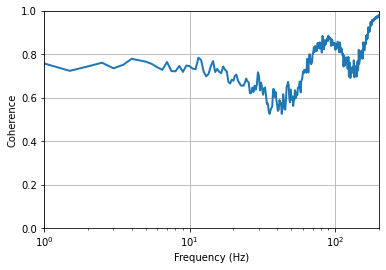

In [ ]:
# Loading in data, plotting coherence of a sample dataset
train_inputs, train_outputs = LoadData(Data['train_files'], Data['stem'], Hpar['receptive_field'])
val_inputs, val_outputs = LoadData(Data['val_files'], Data['stem'], Hpar['receptive_field'])

F = train_inputs[0,Hpar['receptive_field']-1:,:]
x = train_outputs[0,:]

Cyx, faxis = Coherence(F, x, Opt['window_length'], Data['sampling_frequency'])

PlotCoherence(faxis, Cyx, Opt['freq_range'], [])
Hpar['input_shape'] = train_inputs[0,...].shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs))
val_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs))

In [ ]:
model = BuildModel(Hpar)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 819201, 1)]  0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 819199, 6)    24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 819193, 12)   228         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 819193, 12)   108         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
input = model.input
output = model.output
layers = model.layers
outputs = [layer.output for layer in layers]

In [ ]:
x = Conv1D(10, 1, kernel_initializer=tf.keras.initializers.HeUniform(), activation='linear', use_bias=True)(outputs[-2])
# x = Conv1D(5, 1, kernel_initializer=tf.keras.initializers.HeUniform(), activation='linear', use_bias=True)(x)
output = Conv1D(1, 1, kernel_initializer=tf.keras.initializers.HeUniform(), activation='linear', use_bias=True)(x)

In [ ]:
model_new = Model(inputs=input, outputs=output)
model=model_new

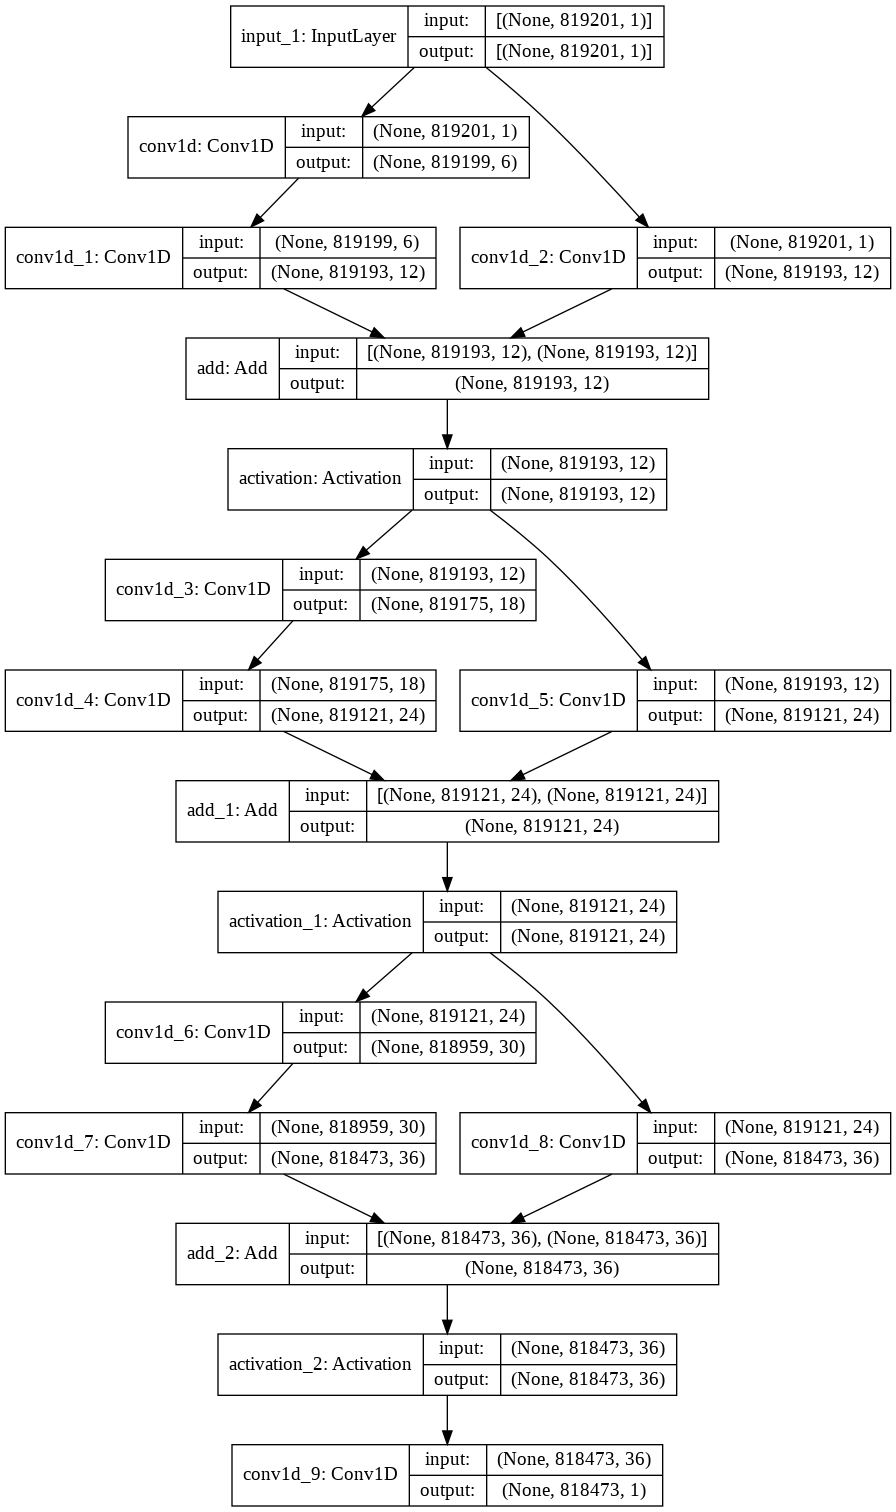

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=False)

In [ ]:
model.compile()
optimizer = tf.keras.optimizers.Adam(learning_rate=Opt['learning_rate'])

In [ ]:
results = TrainModel(model, optimizer, train_dataset, val_dataset, Opt, len(Data['train_files']) , Data['model_save_path']) # Include some sort of validation?

Epoch 000: Loss: 179.744, Cpy_avg: 0.548, Val Loss: 130.379, Val Cpy_avg: 0.672
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 179.744. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 001: Loss: 128.182, Cpy_avg: 0.678, Val Loss: 123.847, Val Cpy_avg: 0.689
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 128.182. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 002: Loss: 124.510, Cpy_avg: 0.687, Val Loss: 122.108, Val Cpy_avg: 0.693
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 124.510. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 003: Loss: 123.059, Cpy_avg: 0.691, Val Loss: 120.553, Val Cpy_avg: 0.697
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 123.059. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 004: Loss: 121.448, Cpy_avg: 0.695, Val Loss: 119.034, Val Cpy_avg: 0.701
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 121.448. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 005: Loss: 119.605, Cpy_avg: 0.699, Val Loss: 117.572, Val Cpy_avg: 0.705
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 119.605. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 006: Loss: 118.250, Cpy_avg: 0.703, Val Loss: 116.235, Val Cpy_avg: 0.708
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 118.250. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 007: Loss: 116.767, Cpy_avg: 0.707, Val Loss: 114.952, Val Cpy_avg: 0.711
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 116.767. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 008: Loss: 115.770, Cpy_avg: 0.709, Val Loss: 113.772, Val Cpy_avg: 0.714
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 115.770. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 009: Loss: 114.362, Cpy_avg: 0.713, Val Loss: 112.572, Val Cpy_avg: 0.717
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 114.362. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 010: Loss: 113.242, Cpy_avg: 0.715, Val Loss: 111.325, Val Cpy_avg: 0.720
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 113.242. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 011: Loss: 111.806, Cpy_avg: 0.719, Val Loss: 110.088, Val Cpy_avg: 0.723
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 111.806. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 012: Loss: 110.606, Cpy_avg: 0.722, Val Loss: 108.729, Val Cpy_avg: 0.727
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 110.606. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 013: Loss: 109.119, Cpy_avg: 0.726, Val Loss: 107.189, Val Cpy_avg: 0.731
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 109.119. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 014: Loss: 107.303, Cpy_avg: 0.730, Val Loss: 105.412, Val Cpy_avg: 0.735
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 107.303. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 015: Loss: 105.328, Cpy_avg: 0.735, Val Loss: 103.475, Val Cpy_avg: 0.740
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 105.328. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 016: Loss: 103.660, Cpy_avg: 0.740, Val Loss: 101.472, Val Cpy_avg: 0.745
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 103.660. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 017: Loss: 101.627, Cpy_avg: 0.745, Val Loss: 99.453, Val Cpy_avg: 0.750
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 101.627. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 018: Loss: 99.451, Cpy_avg: 0.750, Val Loss: 97.465, Val Cpy_avg: 0.755
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 99.451. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 019: Loss: 97.633, Cpy_avg: 0.755, Val Loss: 95.457, Val Cpy_avg: 0.760
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 97.633. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 020: Loss: 95.688, Cpy_avg: 0.760, Val Loss: 93.680, Val Cpy_avg: 0.765
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 95.688. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 021: Loss: 93.538, Cpy_avg: 0.765, Val Loss: 91.912, Val Cpy_avg: 0.769
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 93.538. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 022: Loss: 92.050, Cpy_avg: 0.769, Val Loss: 90.232, Val Cpy_avg: 0.773
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 92.050. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 023: Loss: 90.405, Cpy_avg: 0.773, Val Loss: 88.607, Val Cpy_avg: 0.777
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 90.405. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 024: Loss: 88.551, Cpy_avg: 0.778, Val Loss: 87.121, Val Cpy_avg: 0.781
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 88.551. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 025: Loss: 87.214, Cpy_avg: 0.781, Val Loss: 85.786, Val Cpy_avg: 0.784
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 87.214. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 026: Loss: 85.594, Cpy_avg: 0.785, Val Loss: 84.355, Val Cpy_avg: 0.788
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 85.594. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 027: Loss: 84.175, Cpy_avg: 0.789, Val Loss: 83.136, Val Cpy_avg: 0.791
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 84.175. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 028: Loss: 83.076, Cpy_avg: 0.791, Val Loss: 81.974, Val Cpy_avg: 0.794
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 83.076. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 029: Loss: 81.811, Cpy_avg: 0.794, Val Loss: 80.934, Val Cpy_avg: 0.797
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 81.811. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 030: Loss: 80.795, Cpy_avg: 0.797, Val Loss: 79.895, Val Cpy_avg: 0.799
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 80.795. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 031: Loss: 79.733, Cpy_avg: 0.800, Val Loss: 78.957, Val Cpy_avg: 0.802
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 79.733. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 032: Loss: 79.449, Cpy_avg: 0.800, Val Loss: 78.113, Val Cpy_avg: 0.804
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 79.449. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 033: Loss: 78.351, Cpy_avg: 0.803, Val Loss: 77.545, Val Cpy_avg: 0.805
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 78.351. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 034: Loss: 77.124, Cpy_avg: 0.806, Val Loss: 76.750, Val Cpy_avg: 0.807
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 77.124. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 035: Loss: 76.593, Cpy_avg: 0.808, Val Loss: 75.769, Val Cpy_avg: 0.810
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 76.593. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 036: Loss: 75.798, Cpy_avg: 0.810, Val Loss: 75.168, Val Cpy_avg: 0.811
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 75.798. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 037: Loss: 75.324, Cpy_avg: 0.811, Val Loss: 74.921, Val Cpy_avg: 0.812
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 75.324. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 038: Loss: 75.307, Cpy_avg: 0.811, Val Loss: 75.170, Val Cpy_avg: 0.811
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 75.307. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 039: Loss: 74.583, Cpy_avg: 0.813, Val Loss: 74.332, Val Cpy_avg: 0.813
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 74.583. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 040: Loss: 74.138, Cpy_avg: 0.814, Val Loss: 73.420, Val Cpy_avg: 0.816
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 74.138. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 041: Loss: 73.315, Cpy_avg: 0.816, Val Loss: 72.919, Val Cpy_avg: 0.817
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 73.315. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 042: Loss: 72.650, Cpy_avg: 0.817, Val Loss: 72.531, Val Cpy_avg: 0.818
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 72.650. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 043: Loss: 72.652, Cpy_avg: 0.817, Val Loss: 72.333, Val Cpy_avg: 0.818
Epoch 044: Loss: 72.817, Cpy_avg: 0.817, Val Loss: 71.979, Val Cpy_avg: 0.819
Epoch 045: Loss: 72.672, Cpy_avg: 0.817, Val Loss: 72.248, Val Cpy_avg: 0.818
Epoch 046: Loss: 72.660, Cpy_avg: 0.817, Val Loss: 73.308, Val Cpy_avg: 0.816
Epoch 047: Loss: 72.575, Cpy_avg: 0.818, Val Loss: 71.768, Val Cpy_avg: 0.820
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 72.575. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 048: Loss: 71.856, Cpy_avg: 0.819, Val Loss: 71.160, Val Cpy_avg: 0.821
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 71.856. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 049: Loss: 71.040, Cpy_avg: 0.822, Val Loss: 70.817, Val Cpy_avg: 0.822
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 71.040. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 050: Loss: 70.675, Cpy_avg: 0.822, Val Loss: 70.405, Val Cpy_avg: 0.823
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 70.675. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 051: Loss: 70.434, Cpy_avg: 0.823, Val Loss: 70.416, Val Cpy_avg: 0.823
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 70.434. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 052: Loss: 70.201, Cpy_avg: 0.824, Val Loss: 69.731, Val Cpy_avg: 0.825
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 70.201. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 053: Loss: 69.940, Cpy_avg: 0.824, Val Loss: 69.677, Val Cpy_avg: 0.825
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 69.940. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 054: Loss: 70.160, Cpy_avg: 0.824, Val Loss: 70.522, Val Cpy_avg: 0.823
Epoch 055: Loss: 70.028, Cpy_avg: 0.824, Val Loss: 69.945, Val Cpy_avg: 0.824
Epoch 056: Loss: 69.619, Cpy_avg: 0.825, Val Loss: 69.405, Val Cpy_avg: 0.826
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 69.619. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 057: Loss: 69.227, Cpy_avg: 0.826, Val Loss: 69.750, Val Cpy_avg: 0.825
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 69.227. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 058: Loss: 69.203, Cpy_avg: 0.826, Val Loss: 69.079, Val Cpy_avg: 0.826
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 69.203. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 059: Loss: 68.798, Cpy_avg: 0.827, Val Loss: 69.383, Val Cpy_avg: 0.826
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 68.798. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 060: Loss: 69.428, Cpy_avg: 0.826, Val Loss: 69.222, Val Cpy_avg: 0.826
Epoch 061: Loss: 68.991, Cpy_avg: 0.827, Val Loss: 68.754, Val Cpy_avg: 0.827
Epoch 062: Loss: 68.715, Cpy_avg: 0.827, Val Loss: 68.606, Val Cpy_avg: 0.828
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 68.715. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 063: Loss: 68.173, Cpy_avg: 0.829, Val Loss: 68.469, Val Cpy_avg: 0.828
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 68.173. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 064: Loss: 68.180, Cpy_avg: 0.829, Val Loss: 68.238, Val Cpy_avg: 0.829
Epoch 065: Loss: 68.115, Cpy_avg: 0.829, Val Loss: 68.109, Val Cpy_avg: 0.829
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 68.115. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 066: Loss: 67.899, Cpy_avg: 0.829, Val Loss: 67.952, Val Cpy_avg: 0.829
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 67.899. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 067: Loss: 67.407, Cpy_avg: 0.831, Val Loss: 67.511, Val Cpy_avg: 0.830
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 67.407. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 068: Loss: 67.273, Cpy_avg: 0.831, Val Loss: 67.521, Val Cpy_avg: 0.830
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 67.273. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 069: Loss: 67.592, Cpy_avg: 0.830, Val Loss: 67.429, Val Cpy_avg: 0.831
Epoch 070: Loss: 67.086, Cpy_avg: 0.831, Val Loss: 67.224, Val Cpy_avg: 0.831
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 67.086. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 071: Loss: 66.895, Cpy_avg: 0.832, Val Loss: 67.149, Val Cpy_avg: 0.831
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 66.895. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 072: Loss: 66.598, Cpy_avg: 0.833, Val Loss: 66.629, Val Cpy_avg: 0.833
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 66.598. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 073: Loss: 66.188, Cpy_avg: 0.834, Val Loss: 66.642, Val Cpy_avg: 0.833
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 66.188. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 074: Loss: 66.448, Cpy_avg: 0.833, Val Loss: 66.470, Val Cpy_avg: 0.833
Epoch 075: Loss: 66.383, Cpy_avg: 0.833, Val Loss: 66.449, Val Cpy_avg: 0.833
Epoch 076: Loss: 65.836, Cpy_avg: 0.835, Val Loss: 65.774, Val Cpy_avg: 0.835
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 65.836. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 077: Loss: 65.341, Cpy_avg: 0.836, Val Loss: 65.512, Val Cpy_avg: 0.835
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 65.341. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 078: Loss: 65.357, Cpy_avg: 0.836, Val Loss: 65.751, Val Cpy_avg: 0.835
Epoch 079: Loss: 65.079, Cpy_avg: 0.836, Val Loss: 65.687, Val Cpy_avg: 0.835
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 65.079. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 080: Loss: 65.003, Cpy_avg: 0.837, Val Loss: 65.233, Val Cpy_avg: 0.836
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 65.003. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 081: Loss: 65.177, Cpy_avg: 0.836, Val Loss: 66.077, Val Cpy_avg: 0.834
Epoch 082: Loss: 65.793, Cpy_avg: 0.835, Val Loss: 65.685, Val Cpy_avg: 0.835
Epoch 083: Loss: 64.999, Cpy_avg: 0.837, Val Loss: 64.507, Val Cpy_avg: 0.838
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 64.999. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 084: Loss: 64.313, Cpy_avg: 0.838, Val Loss: 64.438, Val Cpy_avg: 0.838
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 64.313. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 085: Loss: 63.820, Cpy_avg: 0.840, Val Loss: 63.673, Val Cpy_avg: 0.840
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 63.820. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 086: Loss: 63.607, Cpy_avg: 0.840, Val Loss: 63.981, Val Cpy_avg: 0.839
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 63.607. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 087: Loss: 63.586, Cpy_avg: 0.840, Val Loss: 64.452, Val Cpy_avg: 0.838
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 63.586. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 088: Loss: 63.715, Cpy_avg: 0.840, Val Loss: 64.302, Val Cpy_avg: 0.838
Epoch 089: Loss: 63.346, Cpy_avg: 0.841, Val Loss: 64.098, Val Cpy_avg: 0.839
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 63.346. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 090: Loss: 63.168, Cpy_avg: 0.841, Val Loss: 64.322, Val Cpy_avg: 0.838
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 63.168. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 091: Loss: 63.271, Cpy_avg: 0.841, Val Loss: 64.045, Val Cpy_avg: 0.839
Epoch 092: Loss: 63.199, Cpy_avg: 0.841, Val Loss: 62.730, Val Cpy_avg: 0.842
Epoch 093: Loss: 62.666, Cpy_avg: 0.843, Val Loss: 63.124, Val Cpy_avg: 0.841
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 62.666. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 094: Loss: 62.245, Cpy_avg: 0.844, Val Loss: 62.679, Val Cpy_avg: 0.843
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 62.245. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 095: Loss: 61.998, Cpy_avg: 0.844, Val Loss: 63.006, Val Cpy_avg: 0.842
INFO:tensorflow:Assets written to: ./saved_models/model4_s_1/assets
Epoch loss improved to 61.998. Saving model. 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 096: Loss: 62.340, Cpy_avg: 0.843, Val Loss: 63.616, Val Cpy_avg: 0.840
Epoch 097: Loss: 62.692, Cpy_avg: 0.842, Val Loss: 61.918, Val Cpy_avg: 0.844
Epoch 098: Loss: 63.014, Cpy_avg: 0.842, Val Loss: 63.710, Val Cpy_avg: 0.840
Epoch 099: Loss: 62.597, Cpy_avg: 0.843, Val Loss: 62.226, Val Cpy_avg: 0.844
Duration :654.550


Training set performance --- Loss: 59.16747283935547, Cpy_avg: 0.851


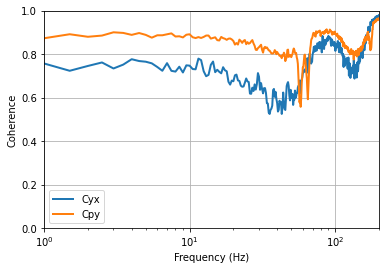

In [ ]:
loss, Cpy_avg, Cpy, Tpy = CoherenceLoss(model, train_inputs[7:10,:,:], train_outputs[7:10,:], Opt)

print('Training set performance --- Loss: {}, Cpy_avg: {:.3f}'.format(loss, Cpy_avg))

PlotCoherence(faxis, np.concatenate((Cyx, Cpy[np.newaxis,:])), Opt['freq_range'], ['Cyx', 'Cpy'])

In [ ]:
loss.shape

TensorShape([])

In [ ]:
%run './CNNfunctions.py'

<Figure size 432x288 with 0 Axes>

Training set performance --- Loss: 26.563, Cpy_avg: 0.933
Test set performance ------- Loss: 26.712, Cpy_avg: 0.933


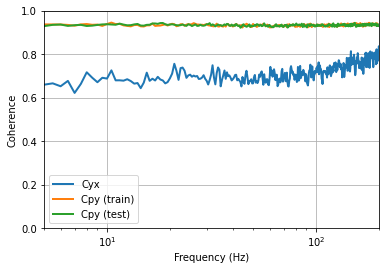

In [ ]:
# Run on test data and compare
test_inputs, test_outputs = LoadData(Data['test_files'], Data['stem'], Hpar['receptive_field'])

test_loss, test_Cpy_avg, test_Cpy, test_Tpy = CoherenceLoss(model, test_inputs[0:3,:,:], test_outputs[0:3,:], Opt)

print('Training set performance --- Loss: {:.3f}, Cpy_avg: {:.3f}'.format(loss, Cpy_avg))
print('Test set performance ------- Loss: {:.3f}, Cpy_avg: {:.3f}'.format(test_loss, test_Cpy_avg))

PlotCoherence(faxis, np.concatenate((Cyx, Cpy[np.newaxis,:], test_Cpy[np.newaxis,:])), np.array([5,200]), ['Cyx', 'Cpy (train)', 'Cpy (test)'])


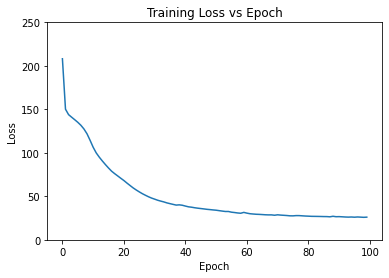

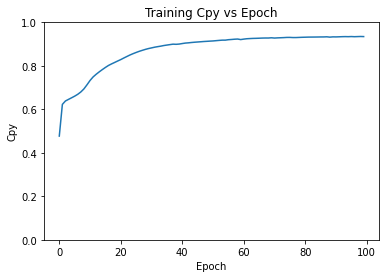

In [ ]:
# Plotting training history
train_loss_results, train_Cpy_results = results
plt.plot(train_loss_results)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.ylim([0, 250])
plt.show()

plt.plot(train_Cpy_results)
plt.xlabel('Epoch')
plt.ylabel('Cpy')
plt.title('Training Cpy vs Epoch')
plt.ylim([0, 1])
plt.show()